In [4]:
#Практична робота №9.
#Використання tensorflow для побудови нейронної мережи.

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Загальна кількість класів, у даному випадку це цифри від 0 до 9
num_classes = 10

# Кількість атрибутів вхідного вектора 28*28 = 784
num_features = 784

# Швидкість навчання нейронної мережі
learning_rate = 0.001

# Максимальна кількість епох
training_steps = 3000

# Перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковому підтримці з batch_size елементів
batch_size = 256

# Кожні 100 ітерацій ми будемо показувати поточне значення функції втрат та точності
display_step = 100

# Кількість нейронів 1-го шару
n_hidden_1 = 128

# Кількість нейронів 2-го шару
n_hidden_2 = 256

In [6]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисленні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо цілочисленні пікселі до типу float32
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [7]:
# Створюємо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    # Перший шар, що складається із 128 нейронів.
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар, що складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):

    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)

    return x3

In [8]:

def cross_entropy(y_pred, y_true):

    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):

    # Місце для вашого коду
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [9]:
# Створюємо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):

  # Для припасування ваг мережі використаємо стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Створюємо список параметрів, що оптимізуються.
    trainable_variables = nn.trainable_variables

    # Обчислюємо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [10]:
# Тренування мережі

# Кожні display_step кроків зберігайте в цьому списку поточну помилку нейромережі
loss_history = []

# Кожні display_step кроків зберігайте в цьому списку поточну точність нейромережі
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):

    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 2419.08984375, Accuracy: 0.0859375
Step: 100, Loss: 321.25677490234375, Accuracy: 0.71484375
Step: 200, Loss: 311.80316162109375, Accuracy: 0.65625
Step: 300, Loss: 171.75875854492188, Accuracy: 0.734375
Step: 400, Loss: 196.44871520996094, Accuracy: 0.75
Step: 500, Loss: 179.97946166992188, Accuracy: 0.75390625
Step: 600, Loss: 180.66162109375, Accuracy: 0.78125
Step: 700, Loss: 167.66204833984375, Accuracy: 0.74609375
Step: 800, Loss: 155.31692504882812, Accuracy: 0.765625
Step: 900, Loss: 151.71600341796875, Accuracy: 0.79296875
Step: 1000, Loss: 153.9068145751953, Accuracy: 0.77734375
Step: 1100, Loss: 127.42350769042969, Accuracy: 0.7890625
Step: 1200, Loss: 167.45419311523438, Accuracy: 0.8046875
Step: 1300, Loss: 159.12127685546875, Accuracy: 0.7734375
Step: 1400, Loss: 125.34793853759766, Accuracy: 0.796875
Step: 1500, Loss: 122.66986083984375, Accuracy: 0.84765625
Step: 1600, Loss: 119.3009033203125, Accuracy: 0.84375
Step: 1700, Loss: 151.66134643554688, Accura

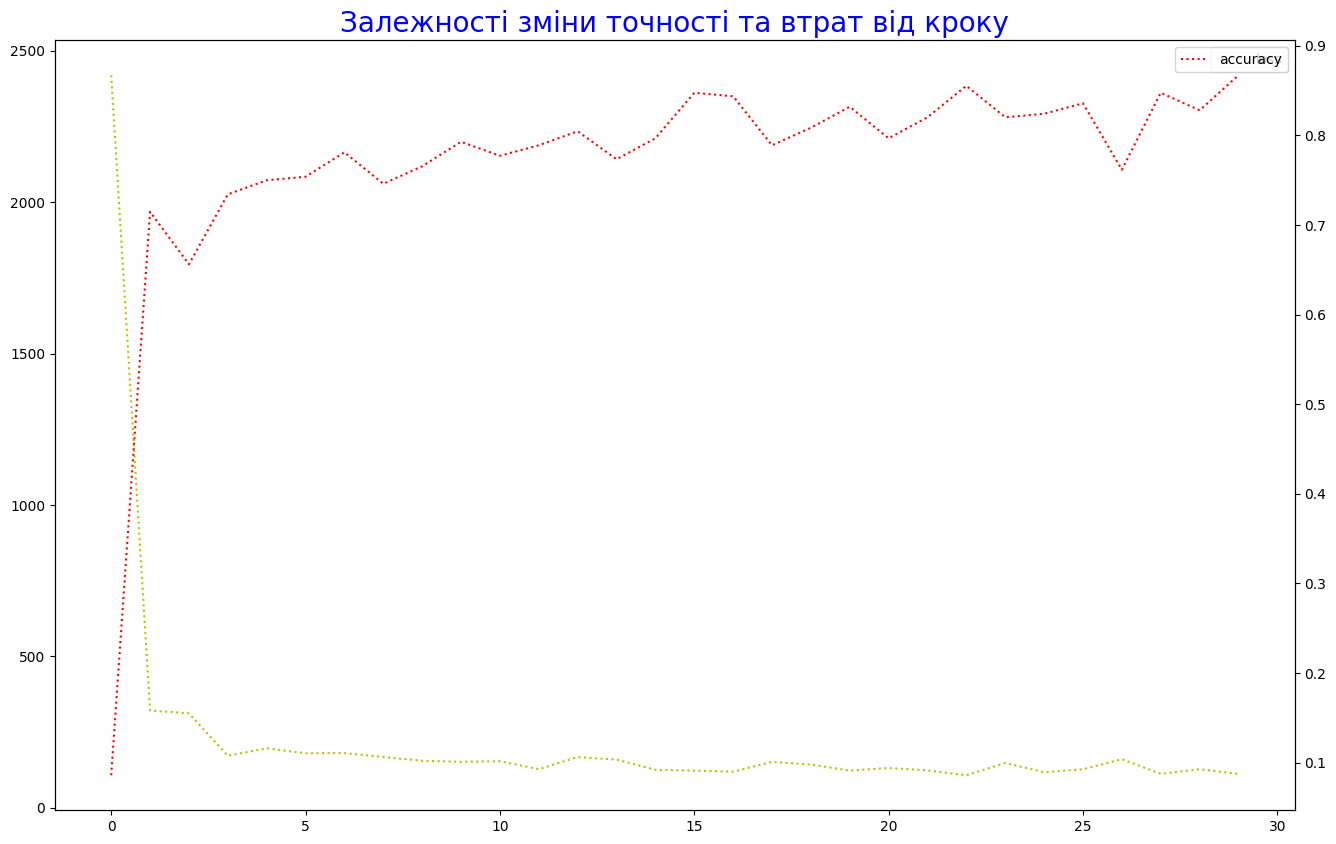

In [11]:
import pandas as pd

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'y', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'r', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='b')
plt.show()

In [12]:
# Обчислюємо точність навченої нейромережі
neural_net_accuracy = accuracy(neural_net(x_train), y_train)

# Обчислюємо точність навченої нейромережі
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.8270833492279053


True: 3 Predict: 3 True
True: 6 Predict: 0 False
True: 8 Predict: 8 True
True: 8 Predict: 8 True
True: 9 Predict: 9 True
True: 3 Predict: 3 True
True: 5 Predict: 5 True
True: 9 Predict: 9 True
True: 2 Predict: 4 False
True: 2 Predict: 8 False


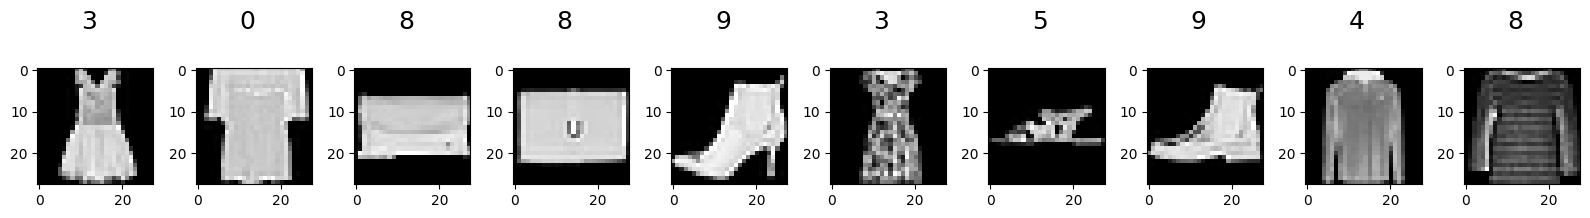

In [13]:
# Протестуємо навчену нейромережу на 10 зображеннях.
# Виведеммо також зображення та випишемо поруч відповідь нейромережі.

test_img = np.random.permutation(x_test.shape[0])[:10]

y_test_true = y_test[test_img]

pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):

    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

Отже, у висновку ми успішно побудували та навчили нейронну мережу для класифікації моделей одягу на базі датасету "fashion_mnist" за вказаними параметрами. Модель показала гарну точність, що свідчить про її ефективність у завданні класифікації.
Ми пройшли через подані етапи:
- Підготовка даних
- Побудова моделі
- Функція втрат та оптимізація
- Тренування моделі
- Тестування моделі
- Відображення результатів